In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import AllChem, PandasTools, SaltRemover, Fingerprints, Scaffolds
from rdkit.Chem.Fingerprints import FingerprintMols
from openeye import oechem, oeomega

%matplotlib inline

### Enamine Amine Building Block Data

In [2]:
pamine = PandasTools.LoadSDF('input/Enamine_Amine_scaffoldsonly.sdf')
pamine_df = pamine.drop(columns=['Structure No', 'IUPAC Name', 'MDL_Number', 'CAS', 
                                 'Stock_weight_G', 'URL', 'Class', 'Subclass',
                                'Price_100mg_USD', 'Price_1g_USD', 'Mw', 'Molecule Name'])

# Fix values in price column
pamine_df.loc[~pamine_df['Price_250mg_USD'].str.isnumeric(), 'Price_250mg_USD'] = 10001
pamine_df = pamine_df.rename(columns={'Price_250mg_USD': 'Price_250mg'})
pamine_df['Price_250mg'] = [float(x) for x in pamine_df['Price_250mg']]

In [7]:
def split_amine(SMILES):
    i = 0
    new_smi = SMILES.split('.')[i]
    # Identify split molecule containing the amine group
    while new_smi.find('N') == -1 and new_smi.find('n') == -1:
        i += 1
        new_smi = SMILES.split('.')[i]
    return new_smi

In [4]:
pg_dict = pickle.load(open('input/PG_SMILES.pkl', 'rb'))

def has_pg(compound_SMILES, pg):
    '''
    Returns True if the SMILES string contains the protecting group of interest
    '''
    ss = oechem.OESubSearch(pg)
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, compound_SMILES)
    oechem.OEPrepareSearch(mol, ss)
    return ss.SingleMatch(mol)

def deprotectGroup(compound_smi, pg_SMIRKS):
    '''
    Returns the SMILES of the deprotected compound after SMIRKS reaction. If the protecting group is not present
    in the compound, the input SMILES is returned.
    '''
    libgen = oechem.OELibraryGen(pg_SMIRKS)
    libgen.SetValenceCorrection(True)

    ## Rewrite the SMILES to remove kekulization for Fmoc specifically
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, compound_smi)
    rewrite_smi = oechem.OECreateIsoSmiString(mol)

    new_mol = oechem.OEGraphMol()
    oechem.OEParseSmiles(new_mol, rewrite_smi)
    libgen.SetStartingMaterial(new_mol, 0)

    if libgen.NumPossibleProducts() > 0:
        for product in libgen.GetProducts():
            new_smi = oechem.OECreateIsoSmiString(product)

        ## If a different pattern than expected got caught by the query and split
        ## we would prefer to just leave that compound as is
        if '.' in new_smi:
            return rewrite_smi
        else:
            return new_smi

    return rewrite_smi

In [5]:
# Find entries containing ions
#pamine_df['split'] = pamine_df['Reagent 1'].apply(lambda smi: len(smi.split('.')))
#pamine_df['split_SMI'] = pamine_df['Reagent 1'].apply(lambda smi: smi.split('.'))
# pamine_ions = pamine_df.loc[pamine_df['split'] > 1].copy(deep=True)
# pamine_ions['r1'] = [x[0] for x in pamine_ions['split_SMI']]
# pamine_ions['r2'] = [x[1] for x in pamine_ions['split_SMI']]
# set(pamine_ions['r2'])

In [6]:
def sort_truncate(SMILES, junk_list):
    # Pick longest substring that is not in the flagged list of solvents/ions
    max_length = 0
    longest_substring = ''
    for s in SMILES.split('.'):
        if s in junk_list:
            pass
        else:
            if len(s) > max_length:
                longest_substring = s
                max_length = len(s)
    return longest_substring

In [6]:
# Clean entries containing ions
pamine_df['BB_SMILES'] = pamine_df['Reagent 1'].apply(split_amine)
pamine_df = pamine_df.drop(columns=['Reagent 1'])
pamine_df = pamine_df.drop_duplicates(subset='BB_SMILES')

pamine_df['mol_SMI'] = pamine_df['ROMol'].apply(Chem.MolToSmiles)

junk_list = ['Cl', 'Br', 'CC(=O)O', 'O=C(O)C(F)(F)F', 'O=C(O)C(=O)O', 'I']
pamine_df['truncate_SMILES'] = pamine_df['mol_SMI'].apply(lambda smi: sort_truncate(smi, junk_list))
pamine_df = pamine_df.drop(columns=['ROMol', 'mol_SMI'])

In [7]:
#pamine_df.to_csv('output/pamine_df.csv', index=False)

### Enamine Primary and Secondary Fmoc amino acids

#### Primary Amino Acids

In [8]:
fmoc_a1 = PandasTools.LoadSDF('input/Enamine_AAs_scaffoldsonly_primary_noacid.sdf')

RDKit WARNING: [12:07:36] skipping block at line 23051: 'BEGIN BOND'


In [9]:
fmoc_aa1 = fmoc_a1[['ID', 'Price_USD_250mg', 'Reagent 1', 'ROMol']].copy(deep=True)

#Fix cost column
fmoc_aa1 = fmoc_aa1.rename(columns={'Price_USD_250mg': 'Price_250mg'})
unknown_char = fmoc_aa1['Price_250mg'].iloc[0][1]
fmoc_aa1['Price_250mg'] = fmoc_aa1['Price_250mg'].str.replace(unknown_char, '')
fmoc_aa1.loc[~fmoc_aa1['Price_250mg'].str.isnumeric(), 'Price_250mg'] = 10001
fmoc_aa1['Price_250mg'] = [float(x) for x in fmoc_aa1['Price_250mg']]

In [10]:
# Clean entries containing ions
fmoc_aa1['BB_SMILES'] = fmoc_aa1['Reagent 1'].apply(lambda smi: sort_truncate(smi, junk_list))
fmoc_aa1 = fmoc_aa1.drop(columns=['Reagent 1'])
fmoc_aa1 = fmoc_aa1.drop_duplicates(subset='BB_SMILES')

fmoc_aa1['mol_SMI'] = fmoc_aa1['ROMol'].apply(Chem.MolToSmiles)
fmoc_aa1['truncate_SMILES'] = fmoc_aa1['mol_SMI'].apply(lambda smi: sort_truncate(smi, junk_list))
fmoc_aa1 = fmoc_aa1.drop(columns=['ROMol', 'mol_SMI'])

In [11]:
#fmoc_aa1.to_csv('output/pamino_acid_df.csv', index=False)

#### Secondary Amino Acids

In [12]:
fmoc_a2 = PandasTools.LoadSDF('input/Enamine_AAs_scaffoldsonly_secondary_noacid.sdf')

In [13]:
fmoc_aa2 = fmoc_a2[['ID', 'Price_USD_250mg', 'Reagent 1', 'ROMol']].copy(deep=True)

#Fix cost column
fmoc_aa2 = fmoc_aa2.rename(columns={'Price_USD_250mg': 'Price_250mg'})
fmoc_aa2['Price_250mg'] = fmoc_aa2['Price_250mg'].str.replace(unknown_char, '')
fmoc_aa2.loc[~fmoc_aa2['Price_250mg'].str.isnumeric(), 'Price_250mg'] = 10001
fmoc_aa2['Price_250mg'] = [float(x) for x in fmoc_aa2['Price_250mg']]

In [14]:
# Clean entries containing ions
fmoc_aa2['BB_SMILES'] = fmoc_aa2['Reagent 1'].apply(lambda smi: sort_truncate(smi, junk_list))
fmoc_aa2 = fmoc_aa2.drop(columns=['Reagent 1'])
fmoc_aa2 = fmoc_aa2.drop_duplicates(subset='BB_SMILES')

fmoc_aa2['mol_SMI'] = fmoc_aa2['ROMol'].apply(Chem.MolToSmiles)
fmoc_aa2['truncate_SMILES'] = fmoc_aa2['mol_SMI'].apply(lambda smi: sort_truncate(smi, junk_list))
fmoc_aa2 = fmoc_aa2.drop(columns=['ROMol', 'mol_SMI'])

In [15]:
print(len(fmoc_aa2['BB_SMILES']))
print(len(set(fmoc_aa2['BB_SMILES'])))

print(len(fmoc_aa2['truncate_SMILES']))
print(len(set(fmoc_aa2['truncate_SMILES'])))

1084
1084
1084
815


In [16]:
#fmoc_aa2.to_csv('output/samino_acid_df.csv', index=False)

### Carboxylic acid building blocks

In [28]:
cooh = PandasTools.LoadSDF('input/Enamine_Acid_scaffoldsonly.sdf')
#cooh = PandasTools.LoadSDF('input/Enamine_Acid_scaffoldsonly.sdf')

RDKit WARNING: [16:53:15] Skipping unrecognized collection type at line 428159: MDLV30/STERAC1 BONDS=(1 8)
RDKit WARNING: [16:53:29] skipping block at line 943702: 'BEGIN BOND'


In [29]:
cooh['fmoc'] = cooh['Reagent 1'].apply(lambda smi: has_pg(smi, pg_dict['fmoc']))
cooh['nboc'] = cooh['Reagent 1'].apply(lambda smi: has_pg(smi, pg_dict['nboc']))

In [30]:
print(len(cooh.loc[cooh['nboc'] == True]))
print(len(cooh.loc[cooh['fmoc'] == True]))

0
0


,Molecule Name,Structure No,Mw,ID,IUPAC Name,MDL_Number,CAS,URL,Stock_weight_G,Price_100mg_USD,Price_250mg_USD,Price_1g_USD,Class,Subclass,Reagent 1,ROMol,fmoc,nboc
0,EN300-56168,1,186.59,EN300-56168,4-chloro-2-methoxybenzoic acid,MFCD00002532,57479-70-6,https://www.enaminestore.com/catalog/EN300-56168,10,19,19,26,CarboxylicAcids,Aromatic_Acids,COc1cc(ccc1C(=O)O)Cl,,False,False

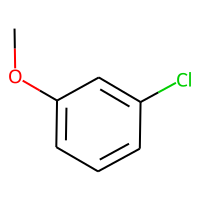

In [31]:
cooh.head(1)

In [33]:
cooh_df = cooh[['ID', 'Price_250mg_USD', 'Reagent 1', 'ROMol']].copy(deep=True)
#Fix cost column
cooh_df = cooh_df.rename(columns={'Price_250mg_USD': 'Price_250mg'})
#cooh_df['Price_250mg'] = cooh_df['Price_250mg'].str.replace(unknown_char, '')
cooh_df.loc[~cooh_df['Price_250mg'].str.isnumeric(), 'Price_250mg'] = 10001
cooh_df['Price_250mg'] = [float(x) for x in cooh_df['Price_250mg']]

In [34]:
junk_list_cooh = ['Cl', 'Br', 'C(=O)(C(F)(F)F)O', 'O', '[Br-]', '[Cl-]', '[I-]', 'N',
                 'OS(=O)(=O)[O-]', 'I']

# Clean entries containing ions
cooh_df['BB_SMILES'] = cooh_df['Reagent 1'].apply(lambda smi: sort_truncate(smi, junk_list_cooh))
cooh_df = cooh_df.drop(columns=['Reagent 1'])
cooh_df = cooh_df.drop_duplicates(subset='BB_SMILES')

In [35]:
junk_list_cooh_mols = ['Cl', 'Br', 'FC(F)F', '[Br-]', '[Cl-]']

cooh_df['mol_SMI'] = cooh_df['ROMol'].apply(Chem.MolToSmiles)
cooh_df['truncate_SMILES'] = cooh_df['mol_SMI'].apply(lambda smi: sort_truncate(smi, junk_list_cooh_mols))
cooh_df = cooh_df.drop(columns=['ROMol', 'mol_SMI'])
cooh_df = cooh_df.loc[cooh_df['BB_SMILES'] != '']

In [36]:
print(len(cooh_df['BB_SMILES']))
print(len(set(cooh_df['BB_SMILES'])))

print(len(cooh_df['truncate_SMILES']))
print(len(set(cooh_df['truncate_SMILES'])))

31091
31091
31091
23687


In [41]:
#cooh_df.to_csv('output/cooh_df.csv', index=False)

In [42]:
cooh_df.groupby(['truncate_SMILES'], as_index=False)['BB_SMILES'].nunique().sort_values(by='BB_SMILES', ascending=False)

,truncate_SMILES,BB_SMILES
22391,[N-]=[N+]=NC1CCCCC1,9
21813,OC1CCCCC1,9
7436,CCc1cccc(OC)c1,9
5367,CCCc1ccccc1,9
22834,c1ccc(C2CC2)cc1,9
...,...,...
8727,CN1CCN(S(=O)(=O)c2ccccc2)CC1,1
8726,CN1CCN(N=O)CC1,1
8725,CN1CCN(Cc2nccs2)CC1,1
8724,CN1CCN(Cc2ccno2)CC1,1


In [44]:
cooh_df.loc[cooh_df['truncate_SMILES'] == 'OC1CCCCC1']

,ID,Price_250mg,BB_SMILES,truncate_SMILES
13202,EN300-26100,19.0,C1CCC(CC1)(C(=O)O)O,OC1CCCCC1
14351,EN300-151572,40.0,C1CC(CC(C1)O)C(=O)O,OC1CCCCC1
16660,EN300-6499500,216.0,C1CC[C@H]([C@@H](C1)C(=O)O)O,OC1CCCCC1
18824,EN300-7327426,487.0,C1CC[C@@H]([C@H](C1)C(=O)O)O,OC1CCCCC1
19062,EN300-252062,431.0,C1C[C@@H](C[C@@H](C1)O)C(=O)O,OC1CCCCC1
25773,EN300-150592,113.0,C1CCC(C(C1)C(=O)O)O,OC1CCCCC1
28247,EN300-97465,637.0,C1CC[C@H]([C@H](C1)C(=O)O)O,OC1CCCCC1
29772,EN300-51638,19.0,C1CC(CCC1C(=O)O)O,OC1CCCCC1
31297,EN300-270314,637.0,C1CC[C@@H]([C@@H](C1)C(=O)O)O,OC1CCCCC1


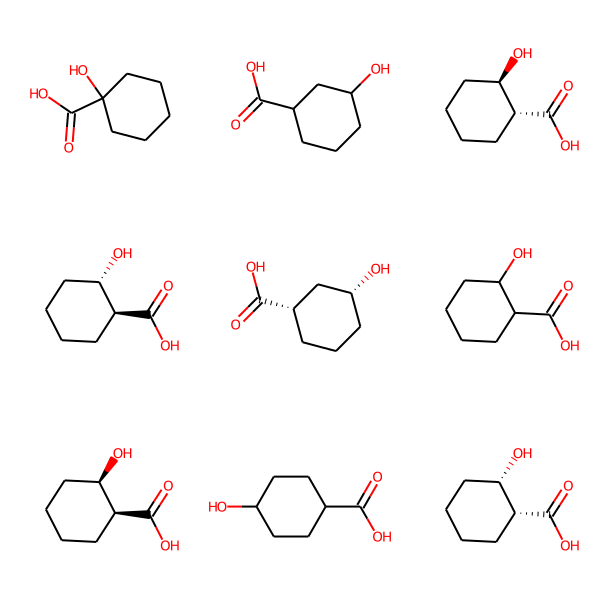

In [45]:
mols = [Chem.MolFromSmiles(smi) for smi in cooh_df.loc[cooh_df['truncate_SMILES'] == 'OC1CCCCC1', 'BB_SMILES']]

Chem.Draw.MolsToGridImage(mols)

In [ ]:
# # the list for the dataframe
# combined_dist_mat = []
# fps = list(merged_df['fp'])
# # compare all fp pairwise without duplicates
# for i in range(1, len(merged_df)): # -1 so the last fp will not be used
#     s = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i]) # +1 compare with the next to the last fp
#     # collect the SMILES and values
#     for m in range(len(s)):
#         combined_dist_mat.append(1-s[m])

In [ ]:
# tri = np.zeros((len(merged_df), len(merged_df)), dtype=np.half)
# np.fill_diagonal(tri, 0)
# idx, col = np.tril_indices(len(merged_df), k=-1)
# tri[idx, col] = combined_dist_mat

In [ ]:
#tri[col, idx] = combined_dist_mat

In [ ]:
#np.save('pamine_fmoc_dist_mat.npy', tri)